## Preamble

In [34]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random

### Set Up Caching Function

In [35]:
def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

### Set Up Plotting Functions

In [36]:
def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways ot allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    #ax.set_xlim([502000,563000])
    #ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

## Load Data

In [37]:
# intract the borough data
airbnb = pd.read_csv('http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/listings.csv')
landuse = pd.read_csv('https://raw.githubusercontent.com/xinyi8888/0013_assignment_2/main/data/Live_Tables_-_Land_Use_Stock_2022_-_LSOA.csv',skiprows=[0,1,2,3,4,6,8,18,33774,33775,33776])
London = gpd.read_file( cache_data('https://github.com/luzhao2000/fsds_A2/blob/main/LSOA2011LondongenMHW.shp.zip?raw=true',
                                  os.path.join('data','geo')) )
ownership = pd.read_csv('https://raw.githubusercontent.com/luzhao2000/fsds_A2/main/census2021.csv')
boroughs = gpd.read_file( cache_data('https://github.com/suiqi37/fsds_assignment/blob/main/'+'Boroughs.gpkg?raw=true',os.path.join('data','geo')) )
print('Done.')

/tmp/ipykernel_71/484962650.py:3: DtypeWarning: Columns (41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  landuse = pd.read_csv('https://raw.githubusercontent.com/xinyi8888/0013_assignment_2/main/data/Live_Tables_-_Land_Use_Stock_2022_-_LSOA.csv',skiprows=[0,1,2,3,4,6,8,18,33774,33775,33776])


Found data/geo/LSOA2011LondongenMHW.shp.zip locally!
Found data/geo/Boroughs.gpkg locally!
Done.


### data processing

In [38]:
#data cleaning
##airbnb data, calculate counts and densities in each area of LSOA level
##na check
# for i in list(airbnb):
#     num=airbnb[airbnb[i].isnull()].shape[0]
#     print(f"{i} has {num} NaN.") #check whether there is na value in latitude and longitude fields, no.
#According to the latitude and longitude coordinates, the attribute data is converted into points for later spatial join
airbnb_points = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))
airbnb_points = airbnb_points.set_crs(epsg=4326)

In [39]:
boroughs = boroughs.to_crs(epsg=4326)

In [40]:
##london shp
london_proj = London.to_crs(epsg=4326) #transform CRS
london_proj = london_proj.loc[:,['LSOA11CD','LSOA11NM','geometry']]
london_proj = london_proj.rename(columns={'LSOA11CD':'LSOA code'})
london_proj = london_proj.rename(columns={'LSOA11NM':'LSOA name'})
london_proj

,LSOA code,LSOA name,geometry
0,E01000001,City of London 001A,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,E01000002,City of London 001B,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,E01000003,City of London 001C,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,E01000005,City of London 001E,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,E01000006,Barking and Dagenham 016A,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."
...,...,...,...
4830,E01033742,Greenwich 007F,"POLYGON ((0.08240 51.49886, 0.08415 51.49803, ..."
4831,E01033743,Greenwich 002H,"POLYGON ((0.11081 51.50980, 0.11227 51.50782, ..."
4832,E01033744,Greenwich 007G,"POLYGON ((0.08072 51.49550, 0.08165 51.49491, ..."
4833,E01033745,Greenwich 002I,"POLYGON ((0.10806 51.50135, 0.10664 51.50021, ..."


In [41]:
##airbnb
airbnb_join = gpd.sjoin(airbnb_points, london_proj, how='left', predicate ='within').loc[:,['id','LSOA code','LSOA name']]
airbnb_LSOA = airbnb_join.groupby(['LSOA code','LSOA name']).count() #count number of airbnb listings in each LSOA level region
airbnb_LSOA.columns = ['listing_counts']
airbnb_LSOA = airbnb_LSOA.reset_index()
airbnb_areas = london_proj.merge(airbnb_LSOA, on='LSOA code', how='outer')
airbnb_areas['area'] = airbnb_areas.area*10**6 #area of each LSOA level region
airbnb_areas['density'] = airbnb_areas['listing_counts'] / airbnb_areas['area']#count density of airbnb listings in each LSOA level region
airbnb_areas

/tmp/ipykernel_71/2483123643.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  airbnb_areas['area'] = airbnb_areas.area*10**6 #area of each LSOA level region


,LSOA code,LSOA name_x,geometry,LSOA name_y,listing_counts,area,density
0,E01000001,City of London 001A,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",City of London 001A,14.0,17.268733,0.810714
1,E01000002,City of London 001B,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",City of London 001B,9.0,29.298116,0.307187
2,E01000003,City of London 001C,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",City of London 001C,19.0,7.422914,2.559642
3,E01000005,City of London 001E,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",City of London 001E,117.0,24.703374,4.736195
4,E01000006,Barking and Dagenham 016A,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",Barking and Dagenham 016A,4.0,18.684225,0.214084
...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,"POLYGON ((0.08240 51.49886, 0.08415 51.49803, ...",Greenwich 007F,15.0,15.963240,0.939659
4831,E01033743,Greenwich 002H,"POLYGON ((0.11081 51.50980, 0.11227 51.50782, ...",Greenwich 002H,8.0,130.108991,0.061487
4832,E01033744,Greenwich 007G,"POLYGON ((0.08072 51.49550, 0.08165 51.49491, ...",Greenwich 007G,23.0,19.710274,1.166904
4833,E01033745,Greenwich 002I,"POLYGON ((0.10806 51.50135, 0.10664 51.50021, ...",Greenwich 002I,6.0,72.303157,0.082984


In [42]:
#ownership
code_o = ownership['geography code'].isin(london_proj['LSOA code'])
ownership_1 = ownership[code_o].sort_values(by=['geography code'])
ownership_2 = ownership_1.reset_index()
ownership_3 = ownership_2.drop(columns=['index','date'])
ownership_4 = ownership_3.rename(columns={'geography code':'LSOA code','geography':'LSOA name',
                                          'Tenure of household: Total: All households':'All households',
                                          'Tenure of household: Owned':'Owned',
                                          'Tenure of household: Owned: Owns outright':'Owns outright',
                                         'Tenure of household: Owned: Owns with a mortgage or loan':'Owns with a mortgage or loan',
                                          'Tenure of household: Shared ownership':'Shared ownership',
                                          'Tenure of household: Shared ownership: Shared ownership':'Shared ownership: Shared ownership',
                                          'Tenure of household: Social rented':'Social rented',
                                          'Tenure of household: Social rented: Rents from council or Local Authority':'Rents from council or Local Authority',
                                         'Tenure of household: Social rented: Other social rented':'Other social rented',
                                         'Tenure of household: Private rented':'Private rented',
                                          'Tenure of household: Private rented: Private landlord or letting agency':'Private landlord or letting agency',
                                         'Tenure of household: Private rented: Other private rented':'Other private rented',
                                          'Tenure of household: Lives rent free':'Lives rent free'})
#ownership数据记录的是2021年的情况，只能假设2022年和2021年情况非常相近，算为limitation
#The ownership data records the situation in 2021, and we can only assume that the situation in 2022 and 2021 is very similar, which is considered a limitation

In [43]:
#landuse
landuse=landuse.drop(['MSOA code','MSOA name','House of Commons Library \nMSOA Names'],axis=1)
landuse=landuse[landuse['LSOA code'].isin(london_proj['LSOA code'])].sort_values(by=['LSOA code'])#all land use data in London based on LSOA level
landuse=landuse.drop(['Total','Total.2','Total.3','Total.4','Total.5', 'Unidentified building',
       'Unidentified general manmade surface', 'Unidentified structure','Unknown', 'Total.6', 'Unnamed: 29', 'Total.7', 'Unnamed: 31',
       'Agricultural buildings', 'Agricultural land', 'Total.8',
       'Forestry and woodland', 'Natural land', 'Rough grassland', 'Water',
       'Total.9', 'Total.10', 'Total.11', 'Total.12', 'Unnamed: 43',
       'Total.13', 'Unnamed: 45', 'Total.14', 'Unnamed: 47', 'Total.15'],axis=1)
landuse=landuse.rename(columns={'Total.1':'Defence'}).replace('-',0) # Replace all "-"s in the original data with zeros, assuming that "-" means that this land use type does not exist
landuse.iloc[:,2:] = landuse.iloc[:,2:].astype(float) #Converting data types
landuse = landuse.reset_index().iloc[:,1:]
entropy = landuse.iloc[:,3:]

In [44]:
# get the entropy
P=pd.DataFrame()
H=pd.DataFrame()

for i in range(entropy.shape[0]):
    landuse_sum = 0
    for x in range(entropy.shape[1]):
        landuse_sum += entropy.iloc[i,x]
    for j in range(entropy.shape[1]):
        P.at[i,j] = entropy.iloc[i,j]/landuse_sum
        

for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P.iloc[i,j] !=0:
            H.at[i,j] = P.iloc[i,j] * math.log(P.iloc[i,j])
        else:
            H.at[i,j] = 0
            
landuse['entropy'] = 0
for p in range(landuse.shape[0]):
    landuse['entropy'][p] = -(H.iloc[p,:].sum(axis = 0))

/tmp/ipykernel_71/2101690111.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landuse['entropy'][p] = -(H.iloc[p,:].sum(axis = 0))


## plot

Text(0.5, 1.0, 'Density')

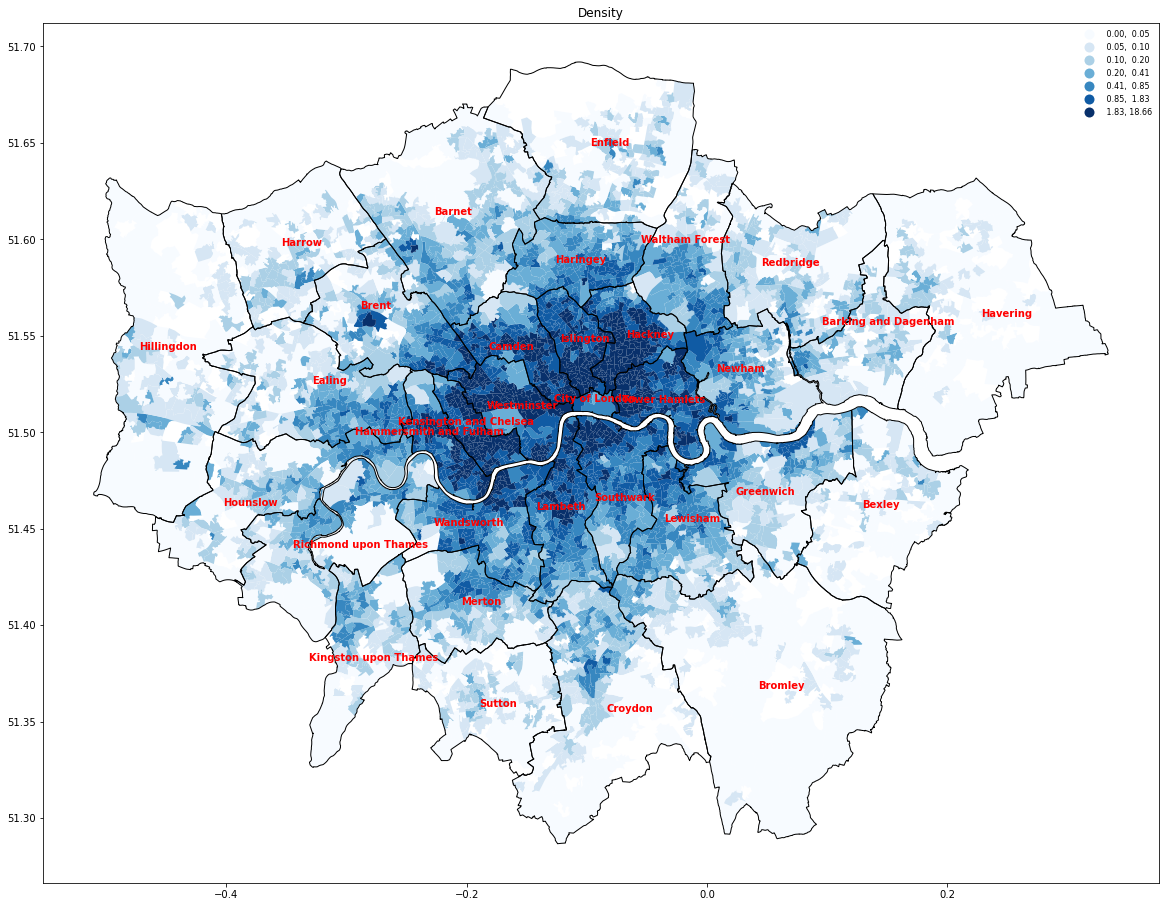

In [45]:
# london airbnb density plot
fig, ax = plt.subplots(1,1, figsize=(20,20))
airbnb_areas.plot(column='density',cmap='Blues', 
         scheme='quantiles', k=7, edgecolor='None', legend=True, legend_kwds={'frameon':False, 'fontsize':8}, linewidth=2.5, ax=ax)
boroughs['coords'] = boroughs['geometry'].apply(lambda x: x.representative_point().coords[:])
boroughs['coords'] = [coords[0] for coords in boroughs['coords']]
boroughs.plot(ax=ax, edgecolor='black', facecolor='none')
for idx, row in boroughs.iterrows():
   plt.annotate(text=row['NAME'], xy=row['coords'], horizontalalignment='center', color='red',fontsize=10,weight='bold')
plt.title('Density')

In [46]:
landuse['Borough'] = landuse['LSOA name'].str.replace(' \d+\w+$','',regex=True)
landuse.Borough.unique()

array(['City of London', 'Barking and Dagenham', 'Barnet', 'Bexley',
       'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster'], dtype=object)

In [47]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

landuse['Subregion'] = landuse.Borough.apply(lambda x: mapping[x])

In [48]:
gdf = pd.merge(london_proj, landuse, left_on='LSOA code', right_on='LSOA code', how='inner')
gdf = gdf.drop(columns=['LSOA name_x','LSOA name_y'])

print(f"Final LSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final LSOA Atlas data frame has shape 4,659 x 19


Text(0.5, 1.0, 'Entropy')

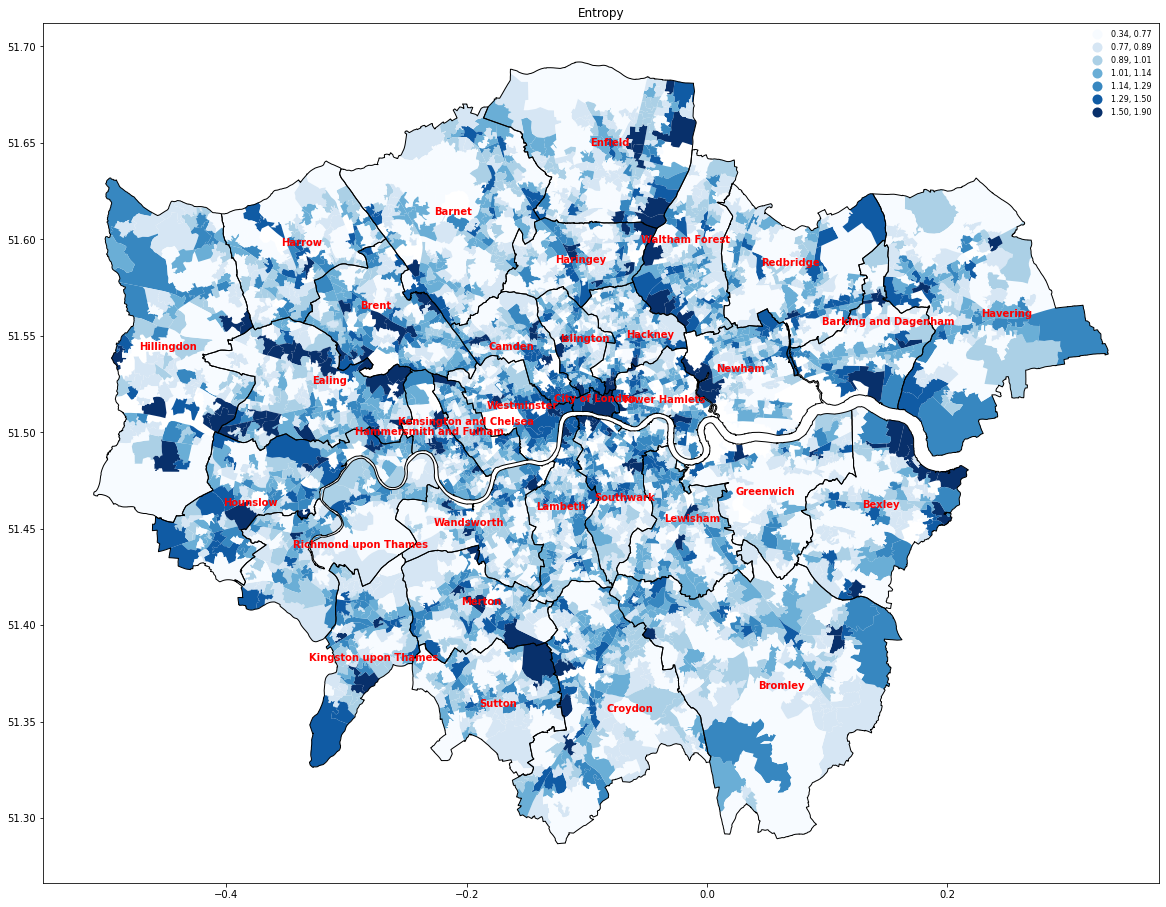

In [49]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
gdf.plot(column='entropy',cmap='Blues', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, legend_kwds={'frameon':False, 'fontsize':8}, linewidth=2.5, ax=ax)
#boroughs.plot(edgecolor='blue', facecolor='none', ax=ax)
boroughs['coords'] = boroughs['geometry'].apply(lambda x: x.representative_point().coords[:])
boroughs['coords'] = [coords[0] for coords in boroughs['coords']]
boroughs.plot(ax=ax, edgecolor='black', facecolor='none')
for idx, row in boroughs.iterrows():
   plt.annotate(text=row['NAME'], xy=row['coords'], horizontalalignment='center', color='red',fontsize=10,weight='bold')
plt.title('Entropy')

In [50]:
#merge all data set together
merge_data = airbnb_areas.merge(landuse, on = 'LSOA code', how='left')
merge_data = merge_data.merge(london_proj, on = 'LSOA code', how='left')
merge_data = merge_data.merge(ownership_4, on = 'LSOA code', how='left')
merge_data = merge_data.rename(columns={'LSOA name_x':'LSOA name','geometry_x':'geometry'}).iloc[:,:-2]
merge_data_na = merge_data.drop(['LSOA name_y'], axis = 1)
merge_data = merge_data_na.replace([np.nan],0)
#merge_data_na.to_csv('merge_data_na.csv',index=False,header=True)
#merge_data.to_csv('merge_data.csv',index=False,header=True)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1499: FutureWarning: Passing 'suffixes' which cause duplicate columns {'LSOA name_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


In [51]:
landuse_corr = merge_data.loc[:,['listing_counts','Community buildings',
       'Leisure and recreational buildings', 'Defence', 'Industry', 'Offices',
       'Retail', 'Storage and warehousing', 'Landfill and waste disposal',
       'Minerals and mining', 'Institutional and communal accommo-dations',
       'Residential', 'Highways and road transport', 'Transport (other)',
       'Utilities','entropy']]

Text(0.5, 1.0, 'Correlation Matrix')

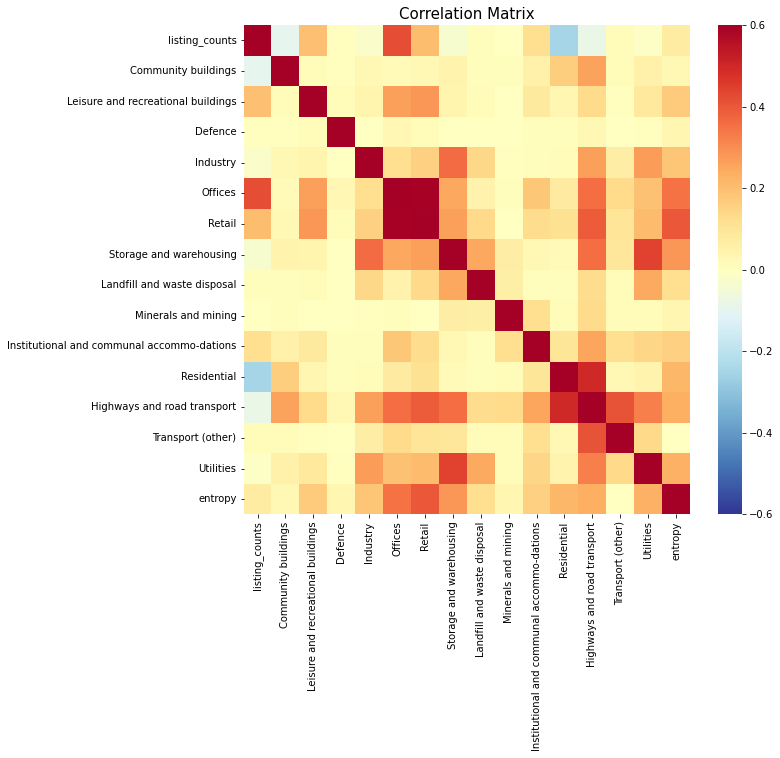

In [52]:
# plot the correlation matrix
f = plt.figure(figsize=(10, 9))
heatmap = sns.heatmap(landuse_corr.corr(), vmin=-0.6, vmax=0.6, cmap='RdYlBu_r')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.title('Correlation Matrix', fontsize=15)

In [53]:
corr = landuse_corr.corr()
corr

,listing_counts,Community buildings,Leisure and recreational buildings,Defence,Industry,Offices,Retail,Storage and warehousing,Landfill and waste disposal,Minerals and mining,Institutional and communal accommo-dations,Residential,Highways and road transport,Transport (other),Utilities,entropy
listing_counts,1.000000,-0.096717,0.197007,0.000788,-0.020424,0.421170,0.206128,-0.030528,0.005995,-0.001229,0.117758,-0.251090,-0.082316,0.018175,-0.013670,0.072317
Community buildings,-0.096717,1.000000,0.013357,0.001002,0.026257,0.019815,0.026066,0.043407,0.007054,0.004907,0.055041,0.162594,0.258264,0.016944,0.051863,0.024257
Leisure and recreational buildings,0.197007,0.013357,1.000000,0.015570,0.038129,0.264388,0.284471,0.038470,0.018529,-0.002349,0.082170,0.037305,0.127630,0.001901,0.084831,0.170112
Defence,0.000788,0.001002,0.015570,1.000000,-0.002700,0.029424,0.014266,-0.000931,-0.002932,-0.001460,0.004925,0.005289,0.026592,-0.001563,0.004387,0.037243
Industry,-0.020424,0.026257,0.038129,-0.002700,1.000000,0.121387,0.156137,0.362299,0.139286,0.004435,0.007594,0.011953,0.263422,0.065671,0.271266,0.187042
Offices,0.421170,0.019815,0.264388,0.029424,0.121387,1.000000,0.593392,0.251933,0.051367,0.008389,0.182613,0.078612,0.356269,0.129417,0.192941,0.347861
Retail,0.206128,0.026066,0.284471,0.014266,0.156137,0.593392,1.000000,0.266211,0.135064,-0.002292,0.124252,0.110534,0.389389,0.098676,0.209396,0.400301
Storage and warehousing,-0.030528,0.043407,0.038470,-0.000931,0.362299,0.251933,0.266211,1.000000,0.250114,0.069673,0.023916,0.021887,0.356929,0.091683,0.444348,0.282180
Landfill and waste disposal,0.005995,0.007054,0.018529,-0.002932,0.139286,0.051367,0.135064,0.250114,1.000000,0.064870,0.007183,0.006177,0.123935,0.012291,0.246785,0.118329
Minerals and mining,-0.001229,0.004907,-0.002349,-0.001460,0.004435,0.008389,-0.002292,0.069673,0.064870,1.000000,0.120863,0.013751,0.128345,0.015320,0.014259,0.037195


In [54]:
ownership_corr = merge_data.loc[:,['listing_counts','Owns outright','Owns with a mortgage or loan','Social rented','Private rented','entropy']]

Text(0.5, 1.0, 'Correlation Matrix')

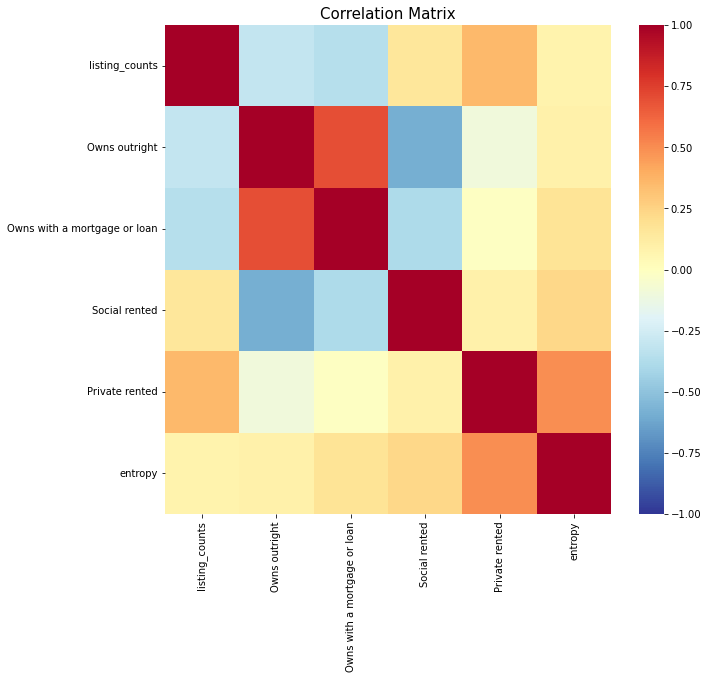

In [55]:
# plot the correlation matrix
f = plt.figure(figsize=(10, 9))
heatmap = sns.heatmap(ownership_corr.corr(), vmin=-1, vmax=1, cmap='RdYlBu_r')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
cb.ax.tick_params(labelsize=9)
plt.title('Correlation Matrix', fontsize=15)

In [56]:
ownership_corr.corr()

,listing_counts,Owns outright,Owns with a mortgage or loan,Social rented,Private rented,entropy
listing_counts,1.000000,-0.305469,-0.353041,0.149259,0.355020,0.072317
Owns outright,-0.305469,1.000000,0.698968,-0.590781,-0.096356,0.088064
Owns with a mortgage or loan,-0.353041,0.698968,1.000000,-0.387216,-0.013612,0.172865
Social rented,0.149259,-0.590781,-0.387216,1.000000,0.088928,0.228695
Private rented,0.355020,-0.096356,-0.013612,0.088928,1.000000,0.497725
entropy,0.072317,0.088064,0.172865,0.228695,0.497725,1.000000
